# DCGAN - Create Images from Random Numbers!

### Generative Adversarial  Networks
Ever since Ian Goodfellow and colleagues [introduced the concept of Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661), GANs have been a popular topic in the field of AI. GANs are an application of unsupervised learning - you don't need labels for your dataset in order to train a GAN. 

The GAN framework composes of two neural networks: a generator network and a discriminator network. 

The generator's job is to take a set of random numbers and produce data (such as images or text).

The discriminator then takes in that data as well as samples of that data from a dataset and tries to determine if is "fake" (created by the generator network) or "real" (from the original dataset). 

During training, the two networks play a game against each other. 
The generator tries to create realistic data, so that it can fool the discriminator into thinking that the data it generated is from the original dataset. At the same time, the discriminator tries to not be fooled - it learns to become better at determining if data is real or fake. 

Since the two networks are fighting in this game, they can be seen as as adversaries, which is where the term "Generative Adverserial Network" comes from. 

### Deep Convolutional Generative Adversarial Networks
This notebook takes a look at Deep Convolutional Generative Adversarial Networks (DCGAN), which combines Convolutional Neural Networks (CNNs) ands GANs. 

We will create a DCGAN that is able to create images of handwritten digits from random numbers. 

The tutorial uses the neural net architecture and guidelines outlined in [this paper](https://arxiv.org/abs/1511.06434), and the MNIST dataset.


## How to Use This Tutorial

You can use this tutorial by executing each snippet of python code in order as it appears in the notebook. 

In this tutorial, we will train DCGAN on MNIST which will ultimately produces two neural networks:
- The first net is the "generator" and creates images of handwritten digits from random numbers.


- The second net is the "discriminator" and determines if the image created by the generator is real (a realistic looking image of handwritten digits) or fake (an image that doesn't look like it came from the original dataset). 

Apart from creating a DCGAN, you'll also learn:

- How to manipulate and iterate through batches images that you can feed into your neural network.


- How to create a custom MXNet data iterator that generates random numbers from a normal distribution.


- How to create a custom training process in MXNet, using lower level functions from the [MXNet Module API](http://mxnet.io/api/python/module.html) such as `.bind()` `.forward()` and `.backward()`. The training process for a DCGAN is more complex than many other neural net's, so we need to use these functions instead of using the higher level `.fit()` function. 


- How to visualize images as they are going through the training process

## Prerequisites

This notebook assumes you're familiar with the concept of CNN's and have implemented one in MXNet. If you haven't, check out [this tutorial](https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/mnist.ipynb), which walks you through implementing a CNN in MXNet. You should also be familiar with the concept of logistic regression. 

Having a basic understanding for MXNet data iterators helps, since we'll create a custom Data Iterator to iterate though random numbers as inputs to our generator network. Take a look at [this tutorial](https://github.com/dmlc/mxnet-notebooks/blob/master/python/basic/data.ipynb) for a better understanding of how MXNet `DataIter` works.

This example is designed to be trained on a single GPU. Training this network on CPU can be slow, so it's recommended that you use a GPU for training. 

To complete this tutorial, you need:

- [MXNet](http://mxnet.io/get_started/setup.html#overview)
- [Python 2.7](https://www.python.org/download/releases/2.7/), and the following libraries for Python: 
    - [Numpy](http://www.numpy.org/) - for matrix math
    - [OpenCV](http://opencv.org/) - for image manipulation
    - [Scikit-learn](http://scikit-learn.org/) - to easily get our dataset
    - [Matplotlib](https://matplotlib.org/) - to visualize our output

## The Data

We need two pieces of data to train our DCGAN:
1. Images of handwritten digits from the MNSIT dataset
2. Random numbers from a normal distribution

Our generator network will use the random numbers as the input to produce images of handwritten digits, and out discriminator network will use images of handwritten digits from the MNIST dataset to determine if images produced by our generator are realistic.

We are going to use the python library, scikit-learn, to get the MNIST dataset. Scikit-learn comes with a function that gets the dataset for us, which we will then manipulate to create our training and testing inputs. 

The MNIST dataset contains 70,000 images of handwritten digits. Each image is 28x28 pixels in size. 


To create random numbers, we're going to create a custom MXNet data iterator, which will returns random numbers from a normal distribution as we need then. 

## Prepare the Data

### 1. Preparing the MNSIT dataset
Let's start by preparing our handwritten digits from the MNIST dataset. We import the fetch_mldata function from scikit-learn, and use it to get the MNSIT dataset. Notice that it's shape is 70000x784. This contains the 70000 images on every row and 784 pixels of each image in the columns of each row. Each image is 28x28 pixels, but has been flattened so that all 784 images are represented in a single list.

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

Next, we'll randomize the handwritten digits by using numpy to create random permutations on the dataset on our rows (images). We'll then reshape our dataset from 70000x786 to 70000x28x28, so that every image in our dataset is arranged into a 28x28 grid, where each cell in the grid represents 1 pixel of the image. 

In [2]:
import numpy as np
#Use a seed so that we get the same random permutation each time
np.random.seed(1)
p = np.random.permutation(mnist.data.shape[0])
X = mnist.data[p]
X = X.reshape((70000, 28, 28))

Since the DCGAN that we're creating takes in a 64x64 image as the input, we'll use OpenCV to resize the each 28x28 image to 64x64 images:

In [3]:
import cv2
X = np.asarray([cv2.resize(x, (64,64)) for x in X])

Each pixel in our 64x64 image is represented by a number between 0-255, that represents the intensity of the pixel. However, we want to input numbers between -1 and 1 into our DCGAN, as suggested by the research paper. To rescale our pixels to be in the range of -1 to 1, we'll divide each pixel by (255/2). This put our images on a scale of 0-2. We can then subtract by 1, to get them in the range of -1 to 1.

In [4]:
X = X.astype(np.float32)/(255.0/2) - 1.0

Ultimately, images are inputted into our neural net from a 70000x3x64x64 array, and they are currently in a 70000x64x64 array. We need to add 3 channels to our images. Typically when we are working with images, the 3 channels represent the red, green, and blue components of each image. Since the MNIST dataset is grayscale, we only need 1 channel to represent our dataset. We will pad the other channels with 0's:

In [5]:
X = X.reshape((70000, 1, 64, 64))
X = np.tile(X, (1, 3, 1, 1))

Finally, we'll put our images into MXNet's NDArrayIter, which will allow MXNet to easily iterate through our images during training. We'll also split up them images into a batches, with 64 images in each batch. Every time we iterate, we'll get a 4 dimensional array with size `(64, 3, 64, 64)`, representing a batch of 64 images.  

In [6]:
import mxnet as mx
batch_size = 64
image_iter = mx.io.NDArrayIter(X, batch_size=batch_size)

## 2. Preparing Random Numbers

We need to input random numbers from a normal distribution to our generator network, so we'll create an MXNet DataIter that produces random numbers for each training batch. The `DataIter` is the base class of [MXNet's Data Loading API](http://mxnet.io/api/python/io.html). Below, we create a class called `RandIter` which is a subclass of `DataIter`. If you want to know more about how MXNet data loading works in python, please look at [this notebook](https://github.com/dmlc/mxnet-notebooks/blob/master/python/basic/data.ipynb). We use MXNet's built in `mx.random.normal` function in order to return the normally distributed random numbers every time we iterate. 

In [7]:
class RandIter(mx.io.DataIter):
    def __init__(self, batch_size, ndim):
        self.batch_size = batch_size
        self.ndim = ndim
        self.provide_data = [('rand', (batch_size, ndim, 1, 1))]
        self.provide_label = []

    def iter_next(self):
        return True

    def getdata(self):
        #Returns random numbers from a gaussian (normal) distribution 
        #with mean=0 and standard deviation = 1
        return [mx.random.normal(0, 1.0, shape=(self.batch_size, self.ndim, 1, 1))]

When we initalize our `RandIter`, we need to provide two numbers: the batch size and how many random numbers we want to produce a single image from. This number is referred to as `Z`, and we'll set this to 100. This value comes from the research paper on the topic. Every time we iterate and get a batch of random numbers, we will get a 4 dimensional array with shape: `(batch_size, Z, 1, 1)`, which in our example is `(64, 100, 1, 1)`. 

In [8]:
Z = 100
rand_iter = RandIter(batch_size, Z)

## Create the Model

Our model has two networks that we will train together - the generator network and the disciminator network. 
Below is an illustration of our generator network:


<img src="dcgan-model.png">
Source: https://arxiv.org/abs/1511.06434

The discriminator works exactly the same way but in reverse - using convolutional layers instead of deconvolutional layers to take an image and determine if it is real or fake.

The DCGAN paper recommends the following best practices for architecting DCGANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

Our model will implement these best practices.

### The Generator
Let's start off by defining the generator network:

In [9]:
no_bias = True
fix_gamma = True
epsilon = 1e-5 + 1e-12

rand = mx.sym.Variable('rand')

g1 = mx.sym.Deconvolution(rand, name='g1', kernel=(4,4), num_filter=1024, no_bias=no_bias)
gbn1 = mx.sym.BatchNorm(g1, name='gbn1', fix_gamma=fix_gamma, eps=epsilon)
gact1 = mx.sym.Activation(gbn1, name='gact1', act_type='relu')

g2 = mx.sym.Deconvolution(gact1, name='g2', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=512, no_bias=no_bias)
gbn2 = mx.sym.BatchNorm(g2, name='gbn2', fix_gamma=fix_gamma, eps=epsilon)
gact2 = mx.sym.Activation(gbn2, name='gact2', act_type='relu')

g3 = mx.sym.Deconvolution(gact2, name='g3', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=256, no_bias=no_bias)
gbn3 = mx.sym.BatchNorm(g3, name='gbn3', fix_gamma=fix_gamma, eps=epsilon)
gact3 = mx.sym.Activation(gbn3, name='gact3', act_type='relu')

g4 = mx.sym.Deconvolution(gact3, name='g4', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=128, no_bias=no_bias)
gbn4 = mx.sym.BatchNorm(g4, name='gbn4', fix_gamma=fix_gamma, eps=epsilon)
gact4 = mx.sym.Activation(gbn4, name='gact4', act_type='relu')

g5 = mx.sym.Deconvolution(gact4, name='g5', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=3, no_bias=no_bias)
generatorSymbol = mx.sym.Activation(g5, name='gact5', act_type='tanh')

Our generator image starts with random numbers that will be obtained from the `RandIter` we created earlier, so we created the `rand` variable for this input. 

We then start creating the model starting with a Deconvolution layer (sometimes called 'fractionally strided layer').  We apply batch normalization and ReLU activation after the Deconvolution layer.

We repeat this process 4 times, applying a `(2,2)` stride and `(1,1)` pad at each Deconvolutional layer, which doubles the size of our image at each layer. By creating these layers, our generator network will have to learn to upsample our input vector of random numbers, `Z` at each layer, so that network output a final image. We also reduce half the number of filters at each layer, reducing dimensionality at each layer. Ultimatley, our output layer is a 64x64x3 layer, representing the size and channels of our image. We use tanh activation instead of relu on the last layer, as recommended by the research on DCGANs. The output of neurons in the final `gout` layer represent the pixels of generated image.  

Notice we used 3 parameters to help us create our model: no_bias, fixed_gamma, and epsilon.
Neurons in our network won't have a bias added to them, this seems to work better in practice for the DCGAN. 
In our batch norm layer, we set `fixed_gamma=True`, which means `gamma=1` for all of our batch norm layers.
`epsilon` is a small number that gets added to our batch norm so that we don't end up dividing by zero. By default, CuDNN requires that this number is greater than `1e-5`, so we add a small number to this value, ensuring this values stays small.

### The Discriminator

Let's now create our discriminator network, which will take in images of handwritten digits from the MNIST dataset and images created by the generator network:

In [10]:
data = mx.sym.Variable('data')

d1 = mx.sym.Convolution(data, name='d1', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=128, no_bias=no_bias)
dact1 = mx.sym.LeakyReLU(d1, name='dact1', act_type='leaky', slope=0.2)

d2 = mx.sym.Convolution(dact1, name='d2', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=256, no_bias=no_bias)
dbn2 = mx.sym.BatchNorm(d2, name='dbn2', fix_gamma=fix_gamma, eps=epsilon)
dact2 = mx.sym.LeakyReLU(dbn2, name='dact2', act_type='leaky', slope=0.2)

d3 = mx.sym.Convolution(dact2, name='d3', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=512, no_bias=no_bias)
dbn3 = mx.sym.BatchNorm(d3, name='dbn3', fix_gamma=fix_gamma, eps=epsilon)
dact3 = mx.sym.LeakyReLU(dbn3, name='dact3', act_type='leaky', slope=0.2)

d4 = mx.sym.Convolution(dact3, name='d4', kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=1024, no_bias=no_bias)
dbn4 = mx.sym.BatchNorm(d4, name='dbn4', fix_gamma=fix_gamma, eps=epsilon)
dact4 = mx.sym.LeakyReLU(dbn4, name='dact4', act_type='leaky', slope=0.2)

d5 = mx.sym.Convolution(dact4, name='d5', kernel=(4,4), num_filter=1, no_bias=no_bias)
d5 = mx.sym.Flatten(d5)

label = mx.sym.Variable('label')
discriminatorSymbol = mx.sym.LogisticRegressionOutput(data=d5, label=label, name='dloss')

We start off by creating the `data` variable, which is used to hold our input images to the discriminator.

The discriminator then goes through a series of 5 convolutional layers, each with a 4x4 kernel, 2x2 stride, and 1x1 pad. These layers half the size of the image (which starts at 64x64) at each convolutional layer. Our model also increases dimensionality at each layer by doubling the number of filters per convolutional layer, starting at 128 filters and ending at 1024 filters before we flatten the output. 

At the final convolution, we flatten the neural net to get one number as the final output of discriminator network. This number is the probability the image is real, as determined by our discriminator. We use logistic regression to determine this probability. When we pass in "real" images from the MNIST dataset, we can label these as `1` and we can label the "fake" images from the generator net as `0` to perform logistic regression on the discriminator network. 

### Prepare the models using the `Module` API

So far we have defined a MXNet `Symbol` for both the generator and the discriminator network.
Before we can train our model, we need to bind these symbols using the `Module` API, which creates the computation graph for our models. It also allows us to decide how we want to initialize our model and what type of optimizer we want to use. Let's set up `Module` for both of our networks:

In [11]:
#Hyperperameters
sigma = 0.02
lr = 0.0002
beta1 = 0.5
ctx = mx.gpu(0)

#=============Generator Module=============
generator = mx.mod.Module(symbol=generatorSymbol, data_names=('rand',), label_names=None, context=ctx)
generator.bind(data_shapes=rand_iter.provide_data)
generator.init_params(initializer=mx.init.Normal(sigma))
generator.init_optimizer(
    optimizer='adam',
    optimizer_params={
        'learning_rate': lr,
        'beta1': beta1,
    })
mods = [generator]

# =============Discriminator Module=============
discriminator = mx.mod.Module(symbol=discriminatorSymbol, data_names=('data',), label_names=('label',), context=ctx)
discriminator.bind(data_shapes=image_iter.provide_data,
          label_shapes=[('label', (batch_size,))],
          inputs_need_grad=True)
discriminator.init_params(initializer=mx.init.Normal(sigma))
discriminator.init_optimizer(
    optimizer='adam',
    optimizer_params={
        'learning_rate': lr,
        'beta1': beta1,
    })
mods.append(discriminator)

First, we create `Modules` for our networks and then bind the symbols that we've created in the previous steps to our modules. 

We use `rand_iter.provide_data` as the  `data_shape` to bind our generator network. This means that as we iterate though batches of data on the generator `Module`, our `RandIter` will provide us with random numbers to feed our `Module` using it's `provide_data` function.

Similarly, we bind the discriminator `Module` to `image_iter.provide_data`, which gives us images from MNIST from the `NDArrayIter` we had set up earlier, called `image_iter`. 

Notice that we're using the `Normal` initialization, with the hyperparameter `sigma=0.02`. This means our weight initializations for the neurons in our networks will random numbers from a Gaussian (normal) distribution with a mean of 0 and a standard deviation of 0.02. 

We also use the adam optimizer for gradient decent. We've set up two hyperparameters, `lr` and `beta1` based on the values used in the DCGAN paper. We're using a single gpu, `gpu(0)` for training.



### Visualizing Our Training

Before we train the model, let's set up some helper functions that will help visualize what our generator is producing, compared to what the real image is:

In [12]:
from matplotlib import pyplot as plt

#Takes the images in our batch and arranges them in an array so that they can be
#Plotted using matplotlib
def fill_buf(buf, num_images, img, shape):
    width = buf.shape[0]/shape[1]
    height = buf.shape[1]/shape[0]
    img_width = (num_images%width)*shape[0]
    img_hight = (num_images/height)*shape[1]
    buf[img_hight:img_hight+shape[1], img_width:img_width+shape[0], :] = img

#Plots two images side by side using matplotlib
def visualize(fake, real):
    #64x3x64x64 to 64x64x64x3
    fake = fake.transpose((0, 2, 3, 1))
    #Pixel values from 0-255
    fake = np.clip((fake+1.0)*(255.0/2.0), 0, 255).astype(np.uint8)
    #Repeat for real image
    real = real.transpose((0, 2, 3, 1))
    real = np.clip((real+1.0)*(255.0/2.0), 0, 255).astype(np.uint8)
    
    #Create buffer array that will hold all the images in our batch
    #Fill the buffer so to arrange all images in the batch onto the buffer array
    n = np.ceil(np.sqrt(fake.shape[0]))
    fbuff = np.zeros((int(n*fake.shape[1]), int(n*fake.shape[2]), int(fake.shape[3])), dtype=np.uint8)
    for i, img in enumerate(fake):
        fill_buf(fbuff, i, img, fake.shape[1:3])
    rbuff = np.zeros((int(n*real.shape[1]), int(n*real.shape[2]), int(real.shape[3])), dtype=np.uint8)
    for i, img in enumerate(real):
        fill_buf(rbuff, i, img, real.shape[1:3])
        
    #Create a matplotlib figure with two subplots: one for the real and the other for the fake
    #fill each plot with our buffer array, which creates the image
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(fbuff)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(rbuff)
    plt.show()

## Fit the Model

Training the DCGAN is a complex process that requires multiple steps.

To fit the model, for every batch of data in our dataset:

1. Use the `Z` vector, which contains our random numbers to do a forward pass through our generator. This outputs the "fake" image, since it's created from our generator.

2. Use the fake image as the input to do a forward and backwards pass through the discriminator network. We set our labels for our logistic regression to `0` to represent that this is a fake image. This trains the discriminator to learn what a fake image looks like. We save the gradient produced in backpropogation for the next step.

3. Do a forwards and backwards pass through the discriminator using a real image from our dataset. Our label for logistic regression will now be `1` to represent real images, so our discriminator can learn to recognize a real image.

4. Update the discriminator by adding the result of the gradient generated during backpropogation on the fake image with the gradient from backpropogation on the real image. 

5. Now that the discriminator has been updated for the this batch, we still need to update the generator. First, do a forward and backwards pass with the same batch on the updated discriminator, to produce a new gradient. Use the new gradient to do a backwards pass


Here's the main training loop for our DCGAN:

Training...
('epoch:', 0, 'iter:', 50)

   From generator:        From MNIST:


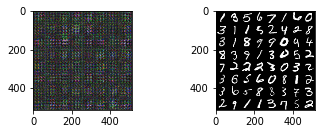

('epoch:', 0, 'iter:', 100)

   From generator:        From MNIST:


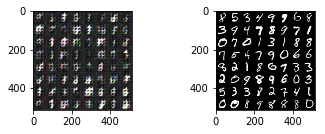

('epoch:', 0, 'iter:', 150)

   From generator:        From MNIST:


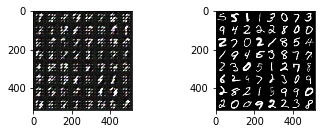

('epoch:', 0, 'iter:', 200)

   From generator:        From MNIST:


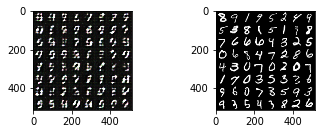

('epoch:', 0, 'iter:', 250)

   From generator:        From MNIST:


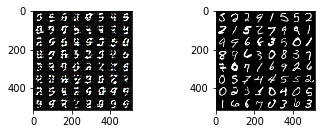

('epoch:', 0, 'iter:', 300)

   From generator:        From MNIST:


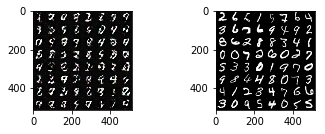

('epoch:', 0, 'iter:', 350)

   From generator:        From MNIST:


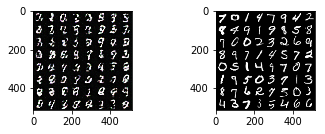

('epoch:', 0, 'iter:', 400)

   From generator:        From MNIST:


In [ ]:
# =============train===============
print('Training...')
for epoch in range(1):
    image_iter.reset()
    for i, batch in enumerate(image_iter):
        #Get a batch of random numbers to generate an image from the generator
        rbatch = rand_iter.next()
        #Forward pass on training batch
        generator.forward(rbatch, is_train=True)
        #Output of training batch is the 64x64x3 image
        outG = generator.get_outputs()
        
        #Pass the generated (fake) image through the discriminator, and save the gradient
        #Label (for logistic regression) is an array of 0's since this image is fake
        label = mx.nd.zeros((batch_size,), ctx=ctx)
        #Forward pass on the output of the discriminator network
        discriminator.forward(mx.io.DataBatch(outG, [label]), is_train=True)
        #Do the backwards pass and save the gradient
        discriminator.backward()
        gradD = [[grad.copyto(grad.context) for grad in grads] for grads in discriminator._exec_group.grad_arrays]
        
        #Pass a batch of real images from MNIST through the discriminator
        #Set the label to be an array of 1's because these are the real images
        label[:] = 1
        batch.label = [label]
        #Forward pass on a batch of MNIST images
        discriminator.forward(batch, is_train=True)
        #Do the backwards pass and add the saved gradient from the fake images to the gradient 
        #generated by this backwards pass on the real images
        discriminator.backward()
        for gradsr, gradsf in zip(discriminator._exec_group.grad_arrays, gradD):
            for gradr, gradf in zip(gradsr, gradsf):
                gradr += gradf
        #Update gradient on the discriminator 
        discriminator.update()

        #Now that we've updated the discriminator, let's update the generator
        #First do a forward pass and backwards pass on the newly updated discriminator
        #With the current batch
        discriminator.forward(mx.io.DataBatch(outG, [label]), is_train=True)
        discriminator.backward()
        #Get the input gradient from the backwards pass on the discriminator,
        #and use it to do the backwards pass on the generator
        diffD = discriminator.get_input_grads()
        generator.backward(diffD)
        #Update the gradients on the generator
        generator.update()
        
        #Increment to the next batch, printing every 50 batches
        i += 1
        if i % 50 == 0:
            print('epoch:', epoch, 'iter:', i)
            print
            print("   From generator:        From MNIST:")

            visualize(outG[0].asnumpy(), batch.data[0].asnumpy())

Here we have our GAN being trained and we can visualize the progress that we're making as our networks train. After every 25 iterations, we're calling the `visualize` function that we created earlier, which creates the visual plots during training. 

The plot on our left is what our generator created (the fake image) in the most recent iteration. The plot on the right is the original (real) image from the MNIST dataset that was inputted to the discriminator on the same iteration. 

As training goes on the generator becomes better at generating realistic images. You can see this happening since images on the left become closer to the original dataset with each iteration. 


## Summary

We've now sucessfully used Apache MXNet to train a Deep Convolutional GAN using the MNIST dataset. 

As a result, we've created two neural nets: a generator, which is able to create images of handwritten digits from random numbers, and a discriminator, which is able to take an image and determine if it is an image of handwritten digits.  

Along the way, we've learned how to do the image manipulation and visualization that's associted with training deep neural nets. We've also learned how to some of MXNet's advanced training functionality to fit our model.

## Acknowledgements
This tutorial is based on [MXNet DCGAN codebase](https://github.com/dmlc/mxnet/blob/master/example/gan/dcgan.py), the [original paper on GANs](https://arxiv.org/abs/1406.2661), as well as [this paper](https://arxiv.org/abs/1511.06434) on deep convolutional GANs.